In [0]:
# %pip install openpyxl==3.1.2

## *** Example Data *****

# Import Lib

In [0]:
import pyspark.sql.functions as fn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import mlflow
import numpy as np
import pandas as pd

# load Data

In [0]:

query = """
select substring_index(PartitionKey,'_',-1) as PartitionKey, Change as GivePoints, from_utc_timestamp(`Timestamp`, 'GMT+7') as `TransactionDate` 
from my_table 
where  year(from_utc_timestamp(`Timestamp`, 'GMT+7')) > 2024
  """
orders = spark.sql(query)

#Consolidate User-Transactions on Date and Summary data to level day

In [0]:
orders_consolidated = (
  orders
    .filter('GivePoints > 0.0') # remove returns from dataset
    .withColumn('TransactionDate', fn.to_date('TransactionDate')) # convert date to just datepart
    .groupBy('PartitionKey', 'TransactionDate') # group on customer and date
      .agg(fn.sum('GivePoints').alias('Point')) # sum sales amount
  )
 
display(orders_consolidated)

#Calculate the RFM Metrics

In [0]:
# get last date in dataset
last_date = (
  orders_consolidated
    .groupBy()
      .agg(fn.max('TransactionDate').alias('lastdate'))
  )
 
# calculate metrics
rfm_metrics = (
  orders_consolidated
    .crossJoin(last_date)
    .groupBy('PartitionKey') # for each customer
      .agg(
        fn.min(fn.datediff('lastdate','TransactionDate')).alias('recency'), # days since last date in dataset (get lowest value as recency)
        fn.countDistinct('TransactionDate').alias('frequency'), # unique dates on which purchases occur
        fn.avg('Point').alias('monetary_value') # avg spend per purchase (works because we've already summed sales per customer-date)
        )
  )
 
# display metrics

# Exploration
- 1. **Frequency**: 
   - Observed Distribution: A majority of customers have low transaction frequency, while a few exhibit extremely high frequencies (outliers).
   
- 2. **Monetary Value**: 
   - Observed Distribution: A significant number of customers have small purchase values, while a few show exceptionally high values, skewing the data.

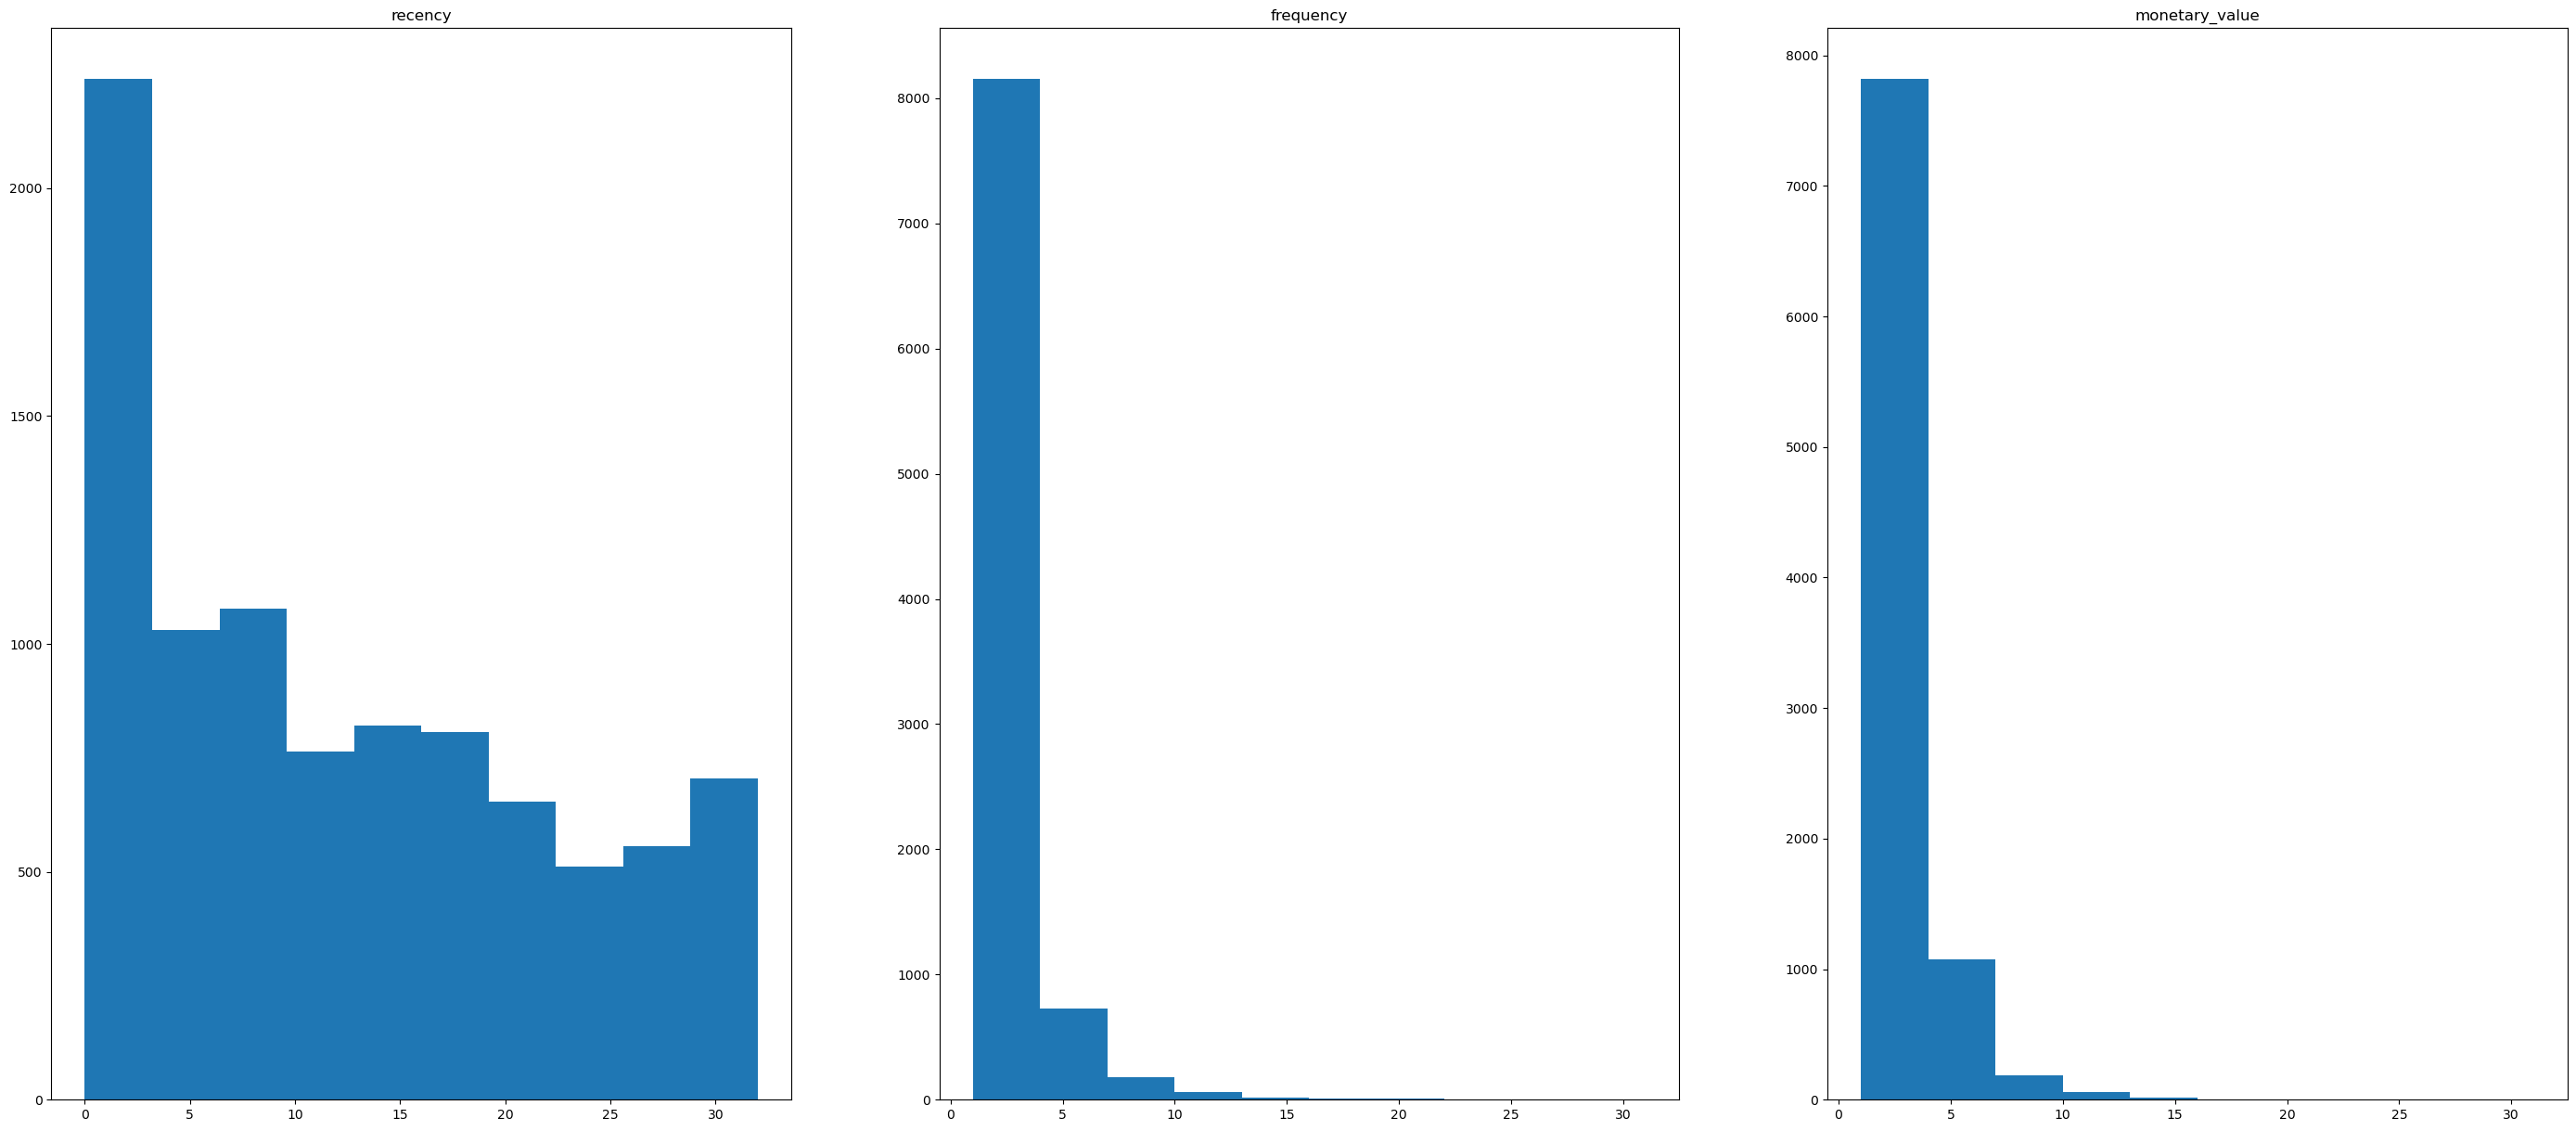

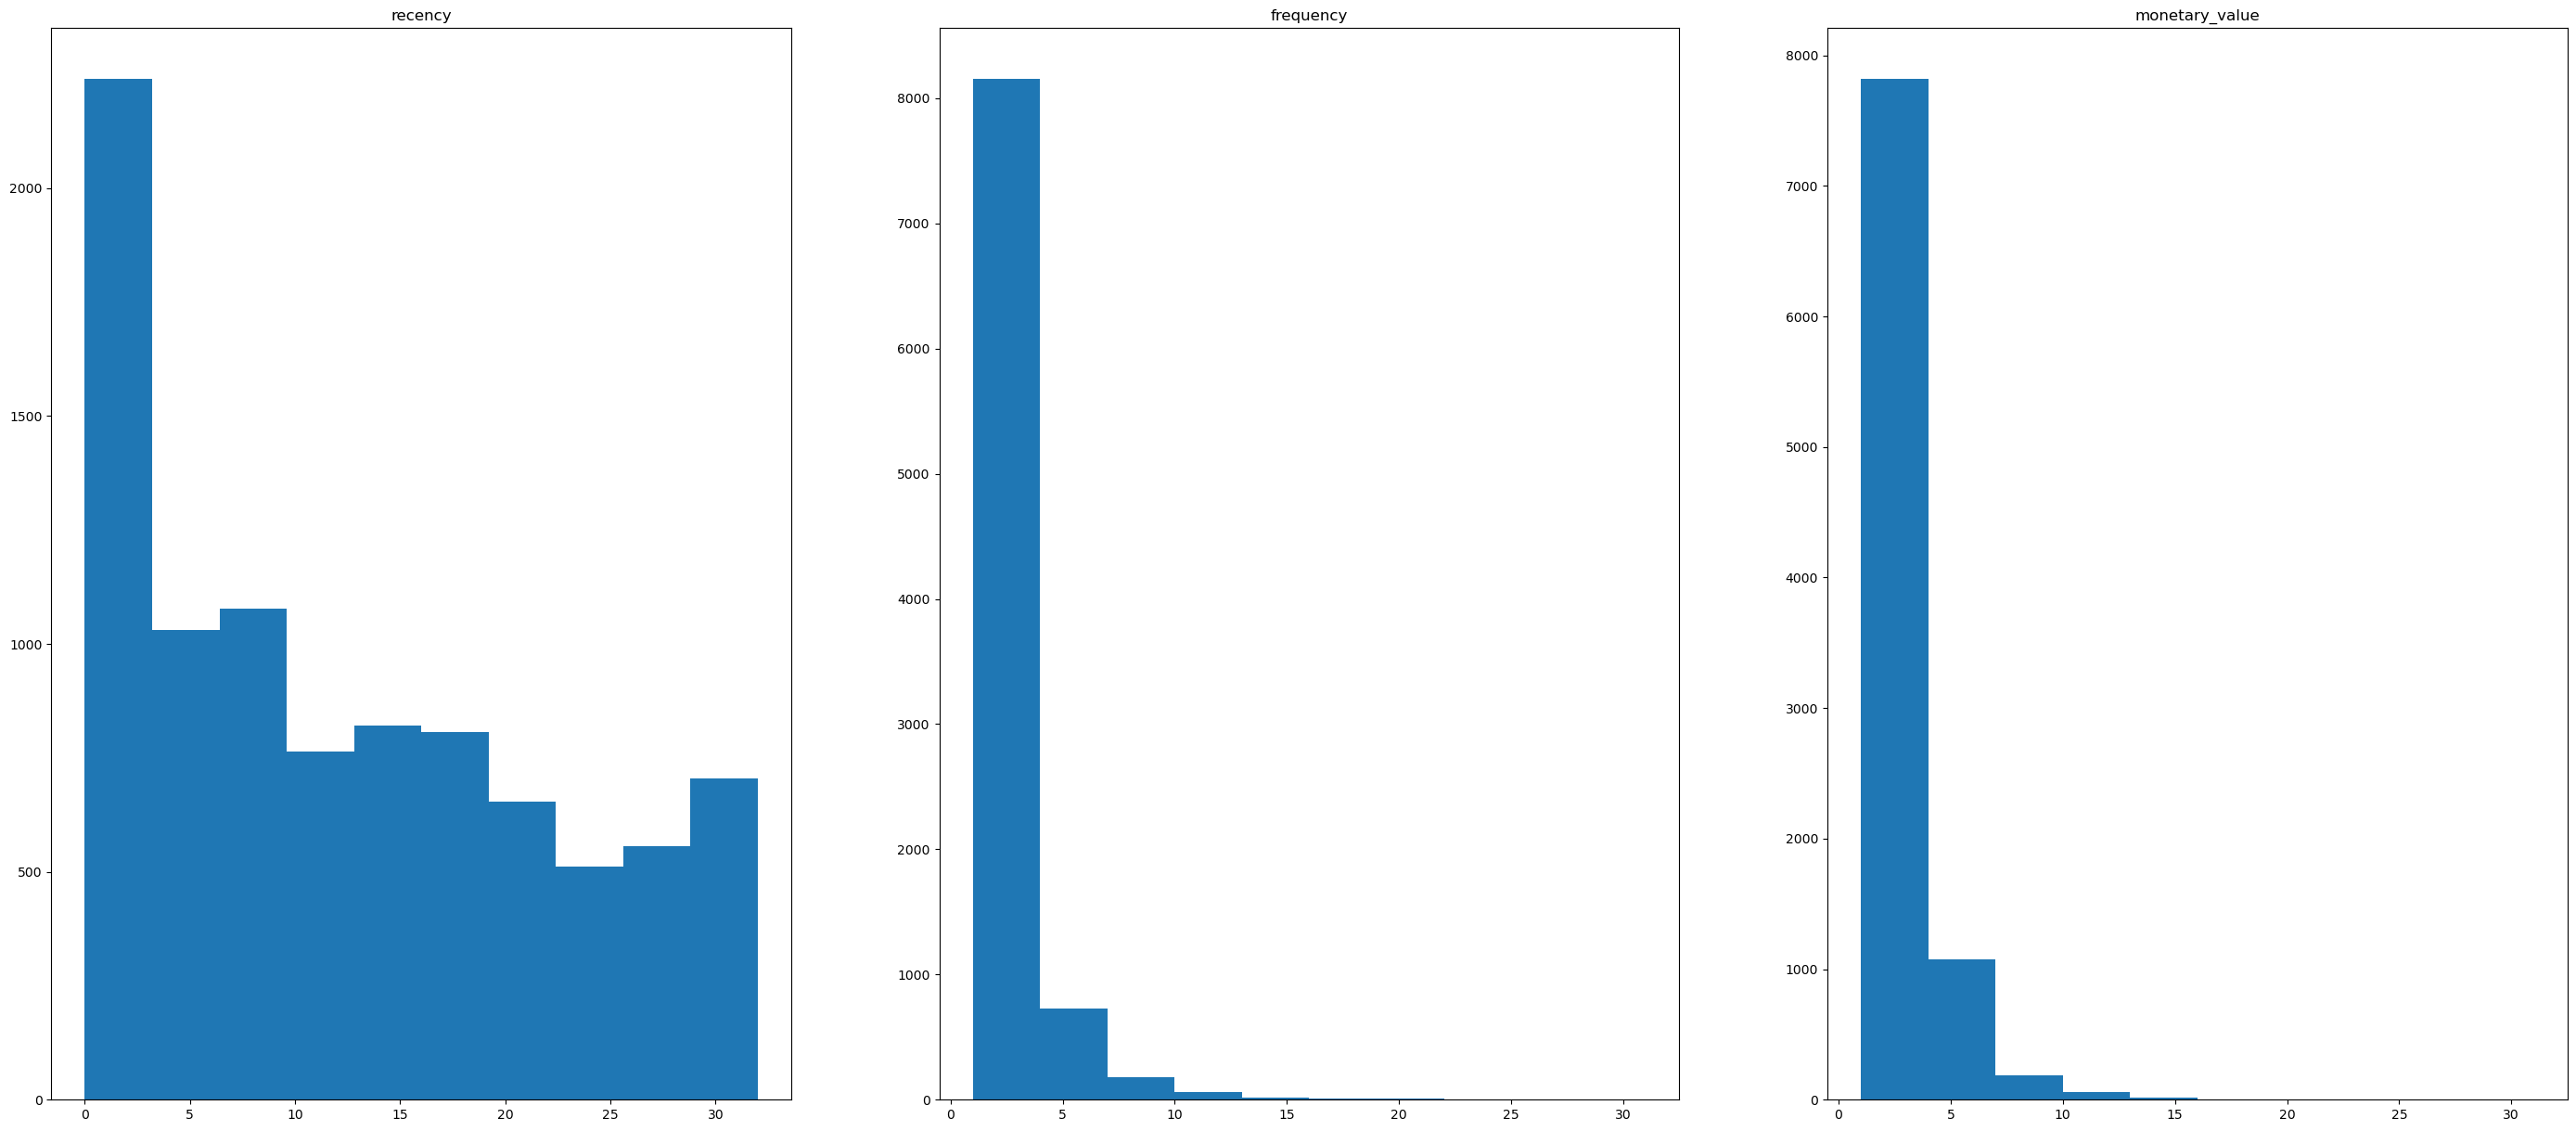

In [0]:
# send metrics to pandas for visualizations
df_pd = rfm_metrics.toPandas()

# convert Decimal values to float
for metric in ['recency', 'frequency', 'monetary_value']:
    df_pd[metric] = df_pd[metric].astype(float)

# configure plot as three charts in a single row
f, axes = plt.subplots(nrows=1, ncols=3, squeeze=True, figsize=(35, 15))

# generate one chart per metric
for i, metric in enumerate(['recency', 'frequency', 'monetary_value']):
    # use metric name as chart title
    axes[i].set_title(metric)
    
    # define histogram chart
    axes[i].hist(df_pd[metric], bins=10)

display(f)

# Cut Outlier ( Now used Clip data)
-    Frequency Adjustment: Values exceeding 30 were capped at 30 using the following logic:
     ```python
     .withColumn('frequency', fn.expr("case when frequency > 30 then 30 else frequency end"))
     ```
-    Monetary  Adjustment: Values above 50,000 were capped at 50,000 using:
     ```python
     .withColumn('monetary_value', fn.expr("case when monetary_value > 50000 then 50000 else monetary_value end")) 

In [0]:

# calculate metrics
rfm_metrics_cleansed = (
  rfm_metrics
    .withColumn('frequency', fn.expr("case when frequency > 30 then 30 else frequency end"))
    .withColumn('monetary_value', fn.expr("case when monetary_value > 50000 then 50000 else monetary_value end"))
  )

In [0]:
display(rfm_metrics_cleansed)

In [0]:
inputs_pd = rfm_metrics_cleansed.toPandas()

# Quantile = >KBinsDiscretizer
- bin = แบ่งข้อมูลเป็นช่วง Quantile 0-4
1. **Define the Binning Transformation**:
   - We use `KBinsDiscretizer` from Scikit-learn to discretize the data into 5 bins. 
   - The `strategy='quantile'` parameter ensures that each bin contains approximately the same number of samples, making the bins balanced.

In [0]:
# defining binning transformation
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
 
# apply binner to each column
col_trans = ColumnTransformer(
  [
    ('r_bin', binner, ['recency']),
    ('f_bin', binner, ['frequency']),
    ('m_bin', binner, ['monetary_value'])
    ],
  remainder='drop'
  )
# invert the recency values so that higher is better
inputs_pd['recency'] = inputs_pd['recency'] * -1
 
# bin the data
bins = col_trans.fit_transform(inputs_pd)
 
# add bins to input data
inputs_pd['r_bin'] = bins[:,0]
inputs_pd['f_bin'] = bins[:,1]
inputs_pd['m_bin'] = bins[:,2]
 
# display dataset
display(inputs_pd)

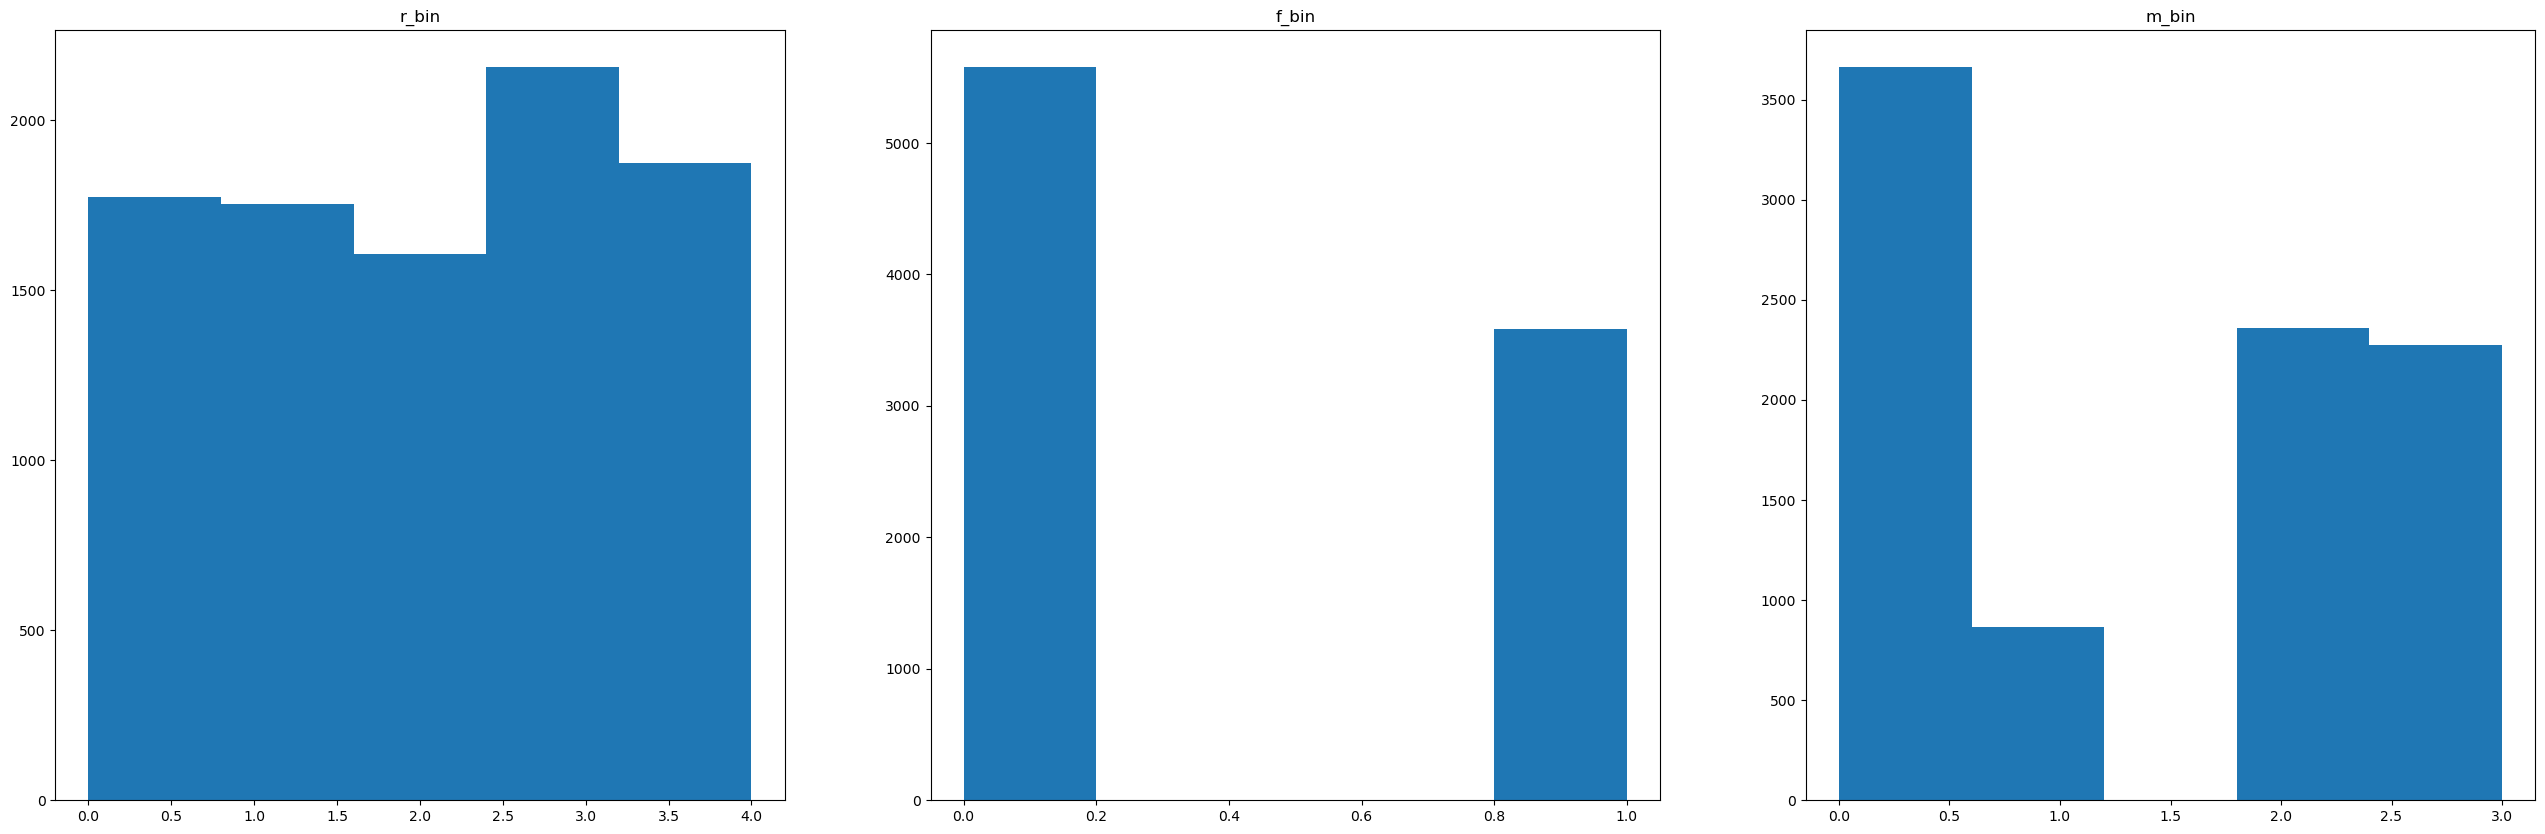

In [0]:
# configure plot as three charts in a single row
f, axes = plt.subplots(nrows=1, ncols=3, squeeze=True, figsize=(32,10))
 
for i, metric in enumerate(['r_bin','f_bin','m_bin']):
   
  # use metric name as chart title
  axes[i].set_title(metric)
  
  # define chart
  axes[i].hist(inputs_pd[metric], bins=5)

#Explore Potential Clustering
- Ref : https://lvdmaaten.github.io/tsne/

The t-SNE algorithm is applied to reduce the 3-dimensional RFM binned data (`r_bin`, `f_bin`, `m_bin`) into a 2-dimensional space.

#Interpretation:

Points with similar hues tend to cluster together, indicating meaningful separations based on the RFM metrics.
Overlapping or dispersed points may suggest the need for additional preprocessing or fine-tuning (e.g., adjusting t-SNE perplexity).

In [0]:
# train the tsne model and compute x and y axes for our values 
# (adjust the perplexity value higher or lower until you receive a visual result that's meaningful)
tsne = TSNE(n_components=2, perplexity=80, n_iter=1000, init='pca', learning_rate='auto')
tsne_results = tsne.fit_transform(inputs_pd[['r_bin','f_bin','m_bin']])
 
# return the axes assignments to our metrics dataset
inputs_pd['tsne_one'] = tsne_results[:,0]
inputs_pd['tsne_two'] = tsne_results[:,1]
 
# display results
display(inputs_pd)

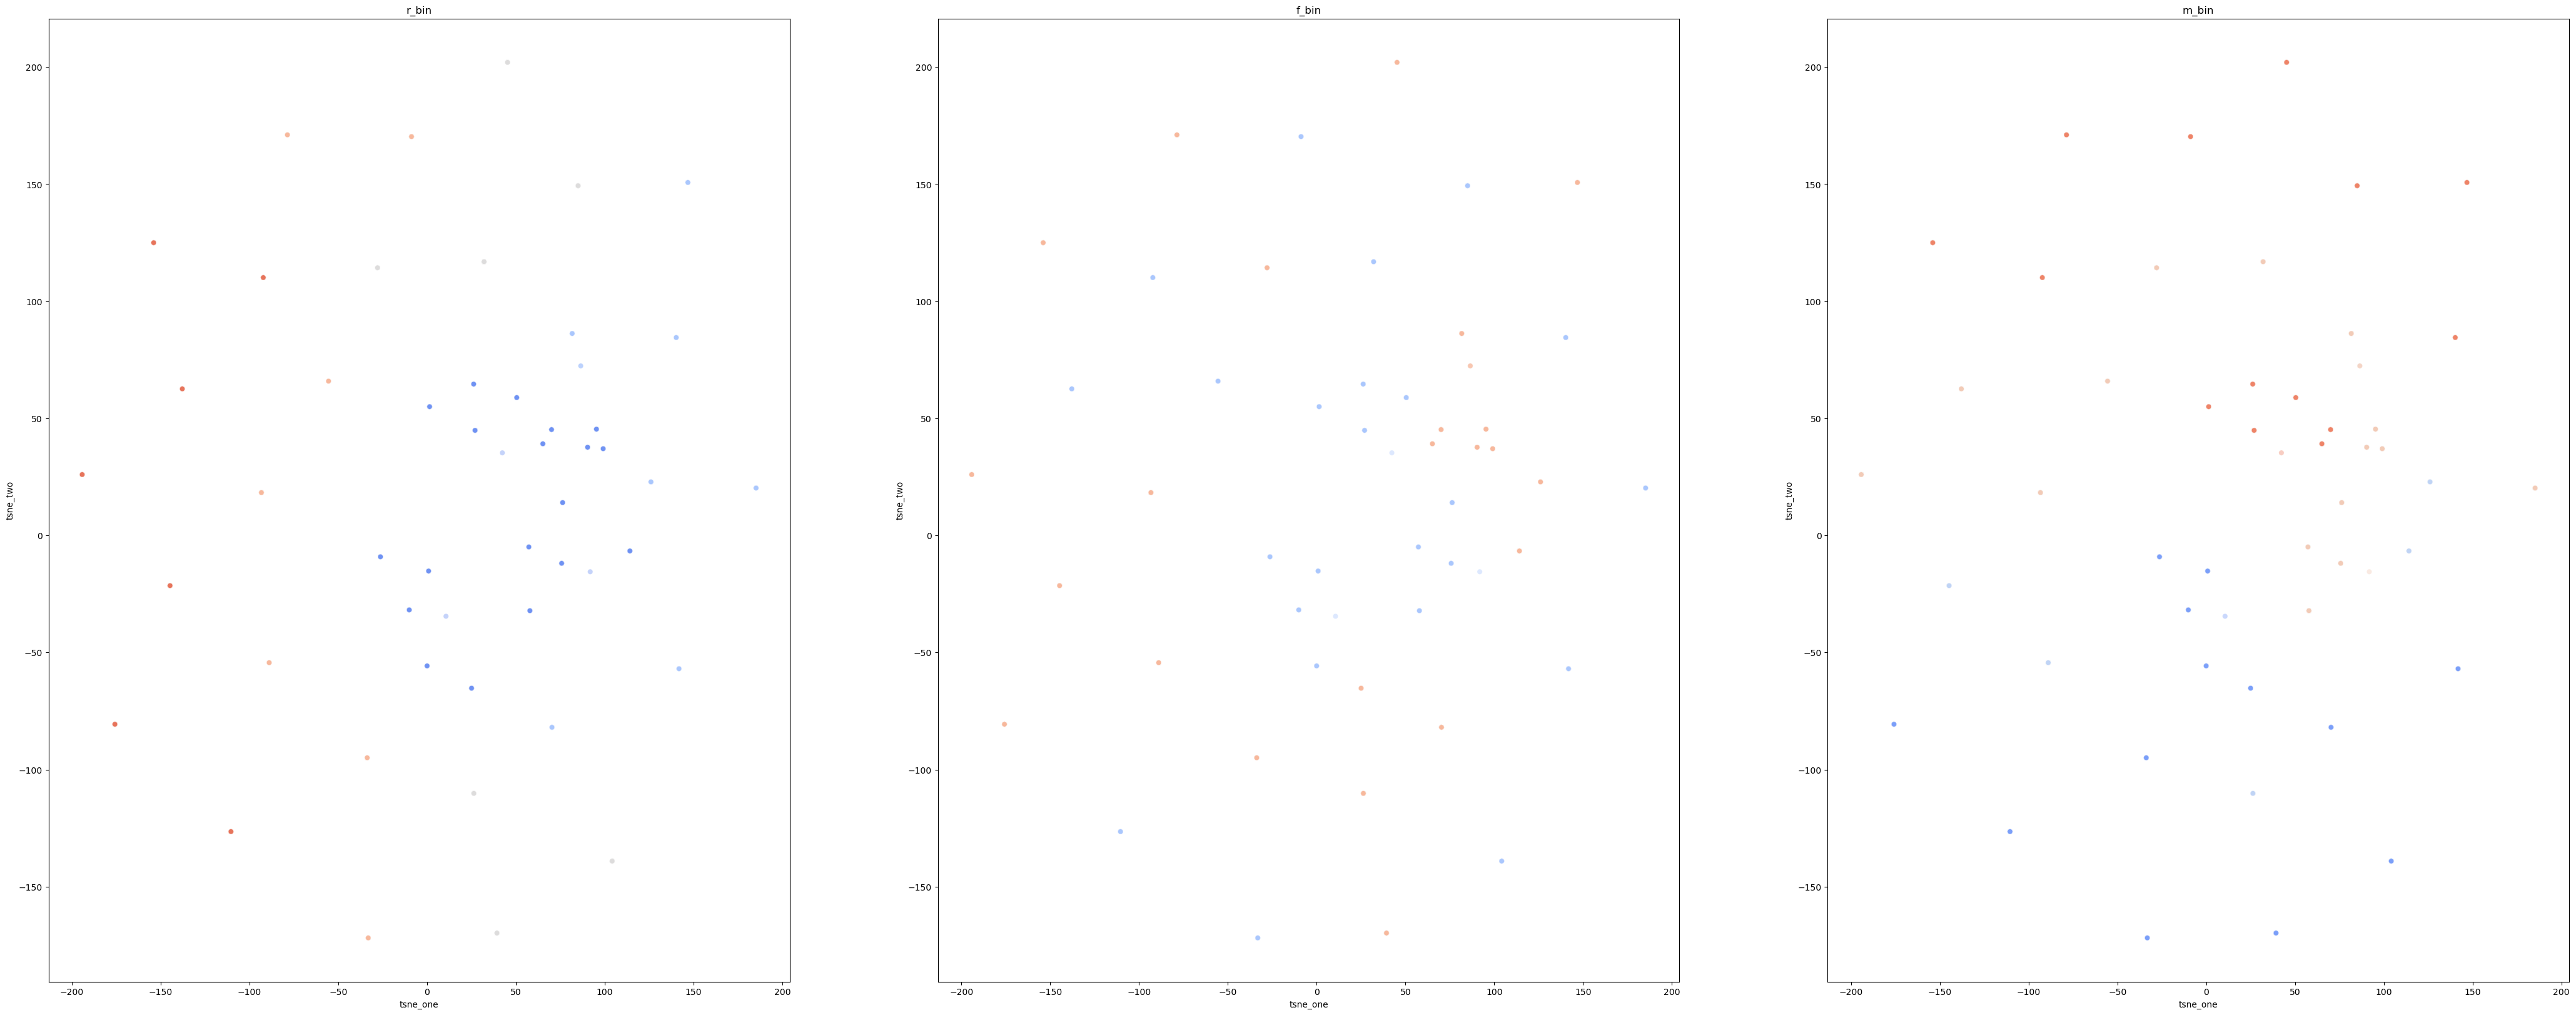

In [0]:
# configure plot as three charts in a single row
f, axes = plt.subplots(nrows=1, ncols=3, squeeze=True, figsize=(52,20))
 
for i, metric in enumerate(['r_bin', 'f_bin', 'm_bin']):
  
  # unique values for this metric
  n = inputs_pd[['{0}'.format(metric)]].nunique()[0]
  
  # use metric name as chart title
  axes[i].set_title(metric)
  
  # define chart
  sns.scatterplot(
    x='tsne_one',
    y='tsne_two',
    hue='{0}'.format(metric),
    palette=sns.color_palette('coolwarm', n),
    data=inputs_pd,
    legend=False,
    alpha=0.4,
    ax = axes[i]
    )

#Cluster Customers Based on RFM Scoresand K-Mean

In [0]:
# define max value of k to explore
max_k = 20
 
# copy binned_pd to each worker node to facilitate parallel evaluation
inputs_pd_broadcast = sc.broadcast(inputs_pd[['r_bin','f_bin','m_bin']])
 
 
# function to train and score clusters based on k cluster count
@fn.udf('float')
def get_silhouette(k):
 
  # train a model on k
  km = KMeans(
    n_clusters=k, 
    init='random',
    n_init=10000
    )
  kmeans = km.fit( inputs_pd_broadcast.value )
 
  # get silhouette score for model 
  silhouette = silhouette_score( 
      inputs_pd_broadcast.value,  # x values
      kmeans.predict(inputs_pd_broadcast.value) # cluster assignments 
      )
  
  # return score
  return float(silhouette)
 
 
# assemble an dataframe containing each k value
iterations = (
  spark
    .range(2, max_k + 1, step=1, numPartitions=sc.defaultParallelism) # get values for k
    .withColumnRenamed('id','k') # rename to k
    .repartition( max_k-1, 'k' ) # ensure data are well distributed
    .withColumn('silhouette', get_silhouette('k'))
  )
  
# release the distributed dataset
inputs_pd_broadcast.unpersist()
 
# display the results of our analysis
display(iterations)

k,silhouette
12,0.5279054
10,0.49327365
11,0.52052045
6,0.44798356
4,0.46951136
14,0.59340024
9,0.47093067
16,0.62426037
18,0.6831705
7,0.43707743


In [0]:
# define model
model = KMeans(
  n_clusters=8, 
  init='random',
  n_init=10000
  )
 
# couple model with transformations
pipe = Pipeline(steps=[
  ('binnerize', col_trans),
  ('cluster', model)
  ])
 
# train pipeline
fitted_pipe = pipe.fit( inputs_pd )
 
# assign clusters
inputs_pd['cluster'] = pipe.predict( inputs_pd )
 
# display cluster assignments
display(inputs_pd)

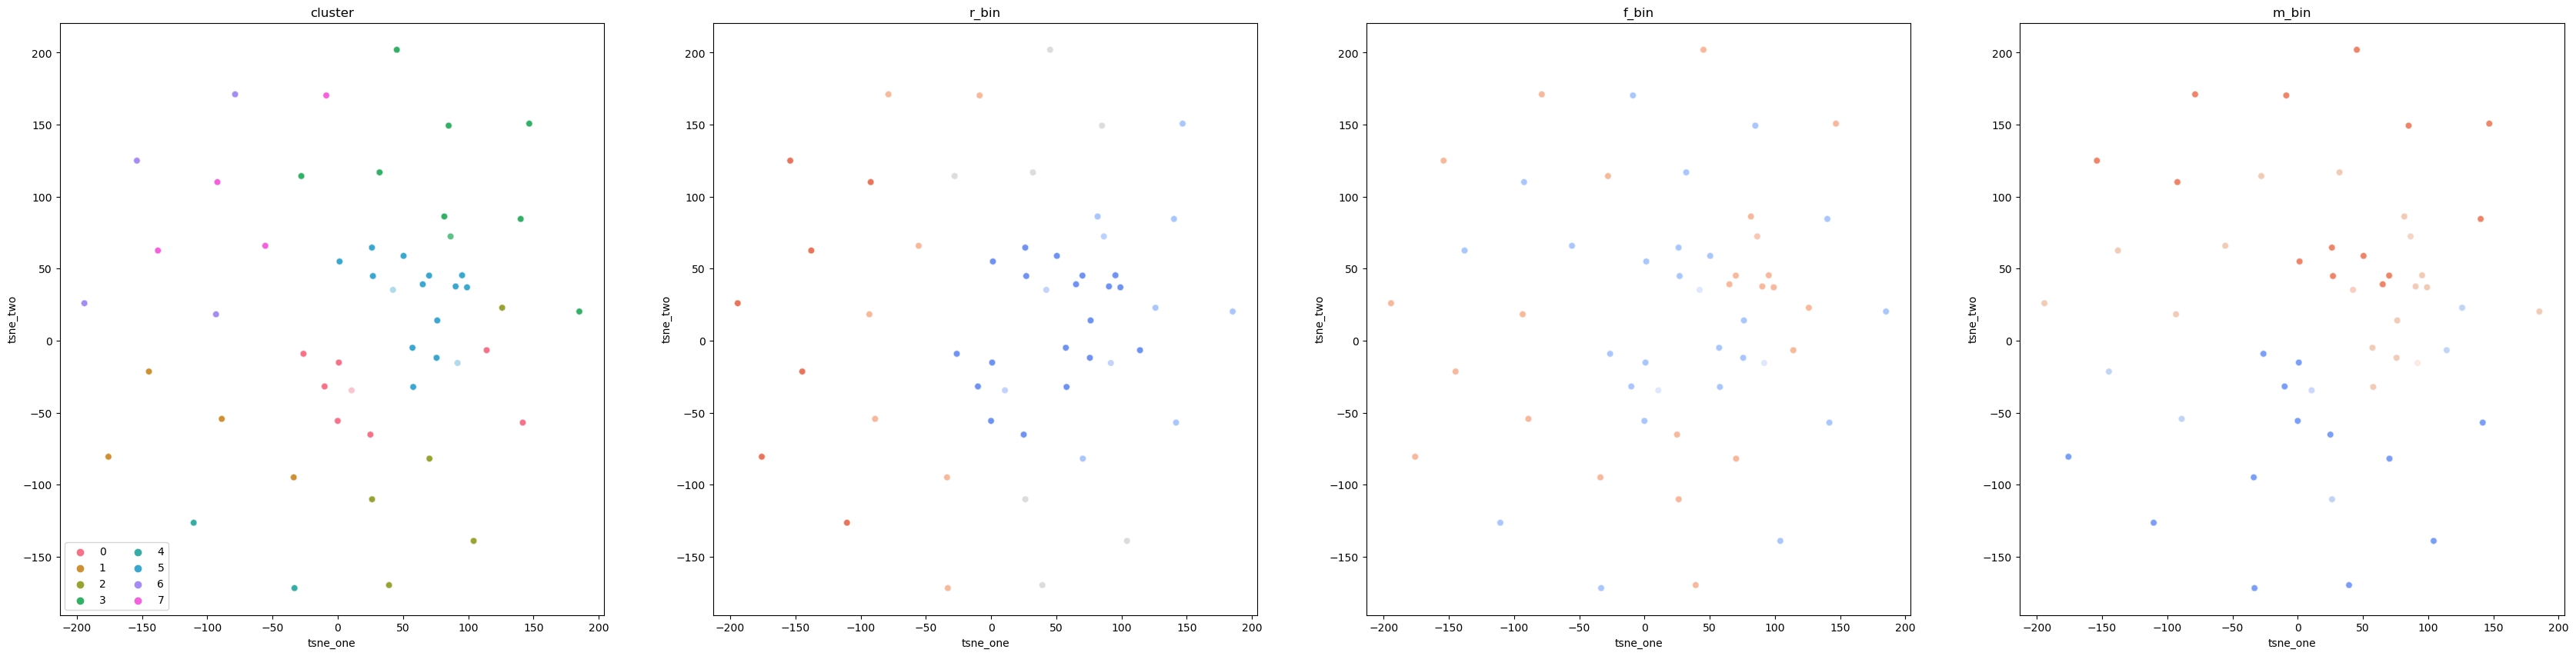

In [0]:
### Distribution Group

f, axes = plt.subplots(nrows=1, ncols=4, squeeze=True, figsize=(42, 10))
 
axes[0].set_title('cluster')
sns.scatterplot(
  x='tsne_one',
  y='tsne_two',
  hue='cluster',
  palette=sns.color_palette('husl', inputs_pd[['cluster']].nunique()[0]),
  data=inputs_pd,
  alpha=0.4,
  ax = axes[0]
  )
axes[0].legend(loc='lower left', ncol=2, fancybox=True)
 
# chart the RFM scores
for i, metric in enumerate(['r_bin', 'f_bin', 'm_bin']):
  
  # unique values for this metric
  n = inputs_pd[['{0}'.format(metric)]].nunique()[0]
  
  # use metric name as chart title
  axes[i+1].set_title(metric)
  
  # define chart
  sns.scatterplot(
    x='tsne_one',
    y='tsne_two',
    hue='{0}'.format(metric),
    palette=sns.color_palette('coolwarm', n),
    data=inputs_pd,
    legend=False,
    alpha=0.4,
    ax = axes[i+1]
    )

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
X = inputs_pd[['r_bin', 'f_bin', 'm_bin']].astype(int)

# 2. Perform K-Means Clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
labels = kmeans.fit_predict(X_scaled)
inputs_pd['Cluster'] = labels

# 3. Map Cluster Names
cluster_names = {
    0: 'Loyal Customers',
    1: 'Promising Leads',
    2: 'Inactive Customers',
    3: 'High-Value Customers',
    4: 'New Customers'
}

inputs_pd['Cluster_Name'] = inputs_pd['Cluster'].map(cluster_names)

# 4. Display the results

In [0]:
display(inputs_pd)

#Identify Cluster Centers

In [0]:
clusters = []
 
# for each cluster
for c in range(0, pipe[-1].n_clusters):
  # get integer values for metrics assocaited with each centroid
  centroids = np.abs(pipe[-1].cluster_centers_[c].round(0).astype('int')).tolist()
  # captuer cluster and centroid values
  clusters += [ [c] + centroids]
 
# convert details to dataframe
clusters_pd = pd.DataFrame(clusters, columns=['cluster','r_bin','f_bin','m_bin'])
 
display(clusters_pd)

cluster,r_bin,f_bin,m_bin
0,0,0,0
1,3,1,0
2,2,1,0
3,1,0,3
4,3,0,0
5,0,0,3
6,3,1,2
7,3,0,2


#Registy Model

In [0]:
model_name = 'rfm_segmentation'

In [0]:

##Set up mlflow experiment
# to ensure this notebook runs in jobs
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().userName().get()
_ = mlflow.set_experiment('/Users/{}/{}'.format(username, model_name))

In [0]:
with mlflow.start_run(run_name='deployment ready'):
 
  mlflow.sklearn.log_model(
    fitted_pipe,
    'model',
    registered_model_name=model_name
    )

In [0]:
# connect to mlflow
client = mlflow.tracking.MlflowClient()
 
# identify model version in registry
latest_model_info = client.search_model_versions(f"name='{model_name}'")[0]
model_version = latest_model_info.version
model_status = latest_model_info.current_stage
 
# move model to production status
if model_status.lower() != 'production':
  client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage='production',
    archive_existing_versions=True
    ) 

/root/.ipykernel/2272/command-4251323590957716-1467825566:11: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


# Result Apply Model with Data

In [0]:
# # define user-defined function for rfm segment assignment
# rfm_segment = mlflow.pyfunc.spark_udf(spark, model_uri=f'models:/{model_name}/production')
 
# # apply function to summary customer metrics
# display(
#   rfm_metrics_cleansed
#     .withColumn('cluster', 
#         rfm_segment(fn.struct('recency','frequency','monetary_value'))
#           )
#   )

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:436)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecution(ChauffeurState.scala:1266)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:983)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:573)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:669)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:687)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:426)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:216)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:424)
	at com.databricks.logging.Usag

In [0]:
# Define a function to create customer segment names
# def create_segment_name(row):
#     recency_segment = ['Least Recent', 'Less Recent', 'Somewhat Recent', 'Recent', 'Least Recent'][row['r_bin']]
#     frequency_segment = ['Infrequent', 'Moderately Frequent', 'Frequent', 'Very Frequent'][row['f_bin']]
#     monetary_segment = ['Low Value', 'Moderate Value', 'High Value', 'Very High Value', 'Highest Value'][row['m_bin']]
    
#     if row['cluster'] == 0:
#         return f"Highest Value, {recency_segment} Customers"
#     elif row['cluster'] == 1:
#         return f"{recency_segment}, {frequency_segment}, {monetary_segment} Lost Customers"
#     elif row['cluster'] == 2:
#         return f"{recency_segment}, {frequency_segment}, {monetary_segment} Lapsed Customers"
#     elif row['cluster'] == 3:
#         return f"{recency_segment}, {frequency_segment}, {monetary_segment} Moderate Value Customers"
#     elif row['cluster'] == 4:
#         return f"{recency_segment}, {frequency_segment}, {monetary_segment} Active Customers"
#     elif row['cluster'] == 5:
#         return f"{recency_segment}, {frequency_segment}, {monetary_segment} Lapsed Customers"
#     elif row['cluster'] == 6:
#         return f"{recency_segment}, {frequency_segment}, {monetary_segment} Inactive Customers"
#     elif row['cluster'] == 7:
#         return f"{recency_segment}, {frequency_segment}, {monetary_segment} Valuable Customers"
#     else:
#         return f"Cluster {row['cluster']}"

# Define a function to create cluster names
def create_segment_name(cluster):
    cluster_names = {
    0: 'Lost Customers',
    1: 'Potential Loyalists',
    2: 'Big Spenders',
    3: 'At Risk',
    4: 'Need Attention',
    5: 'New Customers',
    6: 'Casual Customers',     # Changed from 'Loyal Customers' to 'Casual Customers'
    7: 'Casual Customers'
}
    return cluster_names.get(cluster, f'Cluster {cluster}')
# Apply the function to create cluster names
inputs_pd['cluster_name'] = inputs_pd['cluster'].apply(create_segment_name)

In [0]:
display(inputs_pd)